In [1]:
%load_ext pycodestyle_magic

In [2]:
import pandas as pd
import numpy as np
import filterpy
from filterpy.kalman import KalmanFilter

In [3]:
print("filterpy verison:")
filterpy.__version__

filterpy verison:


'1.4.5'

We load some vertical positon data of a guy running in the mountains.

In [4]:
def load_df(fname):
    """Load the dataFrame."""
    df = pd.read_csv(fname, na_values=[''], sep=';', encoding="utf-8", names=["Time (s)", "Position (m)"])
    return df


# import the data for the kalman filtering
fname = 'kalman_data.csv'
df = load_df(fname)

Let's see what the data looks like

In [5]:
df

,Time (s),Position (m)
0,0,0.000000
1,1,0.600000
2,2,1.210000
3,3,1.817999
4,4,2.431995
...,...,...
996,996,672.005596
997,997,672.399868
998,998,672.790720
999,999,673.178173


# Model

Simple linear model taking into account the speed and the acceleration.

In [6]:
def set_velocity_model(df):

    # get the time step
    dt = df.index[1] - df.index[0]

    # transition_matrix
    F = [[1,  dt,   0.5*dt*dt],
         [0,   1,          dt],
         [0,   0,           1]]

    # observation_matrix
    H = [[1, 0, 0]]

    # transition_covariance
    Q = [[   1,     0,     0],
         [   0,  1e-4,     0],
         [   0,     0,  1e-6]]

    # observation_covariance -> must be two dimensionnal
    R = [[0.04]] # max error = 0.6m

    # initial_state_mean
    X0 = [[0, 0, 0]]

    # initial_state_covariance
    P0 = [[ 10,    0,   0],
          [  0,    1,   0],
          [  0,    0,   1]]

    n_timesteps = df.shape[0]
    n_dim_state = 3
    n_dim_obs = 1

    return df, F, H, Q, R,X0, P0, n_timesteps, n_dim_state, n_dim_obs


def handle_velocity_model(df, key, smoothing=False):

    df, F, H, Q, R,X0, P0, n_timesteps, n_dim_state, n_dim_obs = set_velocity_model(df)
   
    kf = KalmanFilter(dim_x=n_dim_state, dim_z=n_dim_obs)

    # Assign the initial value for the state (position and velocity and acceleration).
    kf.X = np.array(X0) 
    # Define the state transition matrix:
    kf.F = np.array(F)
    # Define the measurement function (observation_matrices)
    kf.H = np.array(H)
    # Define the state covariance matrix. Here I take advantage of the fact that P already contains np.eye(dim_x), and just multiply by the uncertainty:
    kf.P = np.array(P0)  # f.P *= 1000.
    # Now assign the measurement noise. Here the dimension is 1x1, so I can use a scalar = observation_covariance.
    kf.R = np.array(R)
    # Finally, I will assign the process noise. Here I will take advantage of another FilterPy library function:
    # from filterpy.common import Q_discrete_white_noise
    # kf.Q = Q_discrete_white_noise(dim=2, dt=1, var=0.13)
    
    kf.Q = np.array(Q)  # transition_covariance

    # Masking invalid values
    input_values = np.ma.masked_invalid(df[key].values)
    
    saver = filterpy.common.Saver(kf)
    
    # estimate hidden state
    # state_means, state_covariances = kf.batch_filter(input_values)
    state_means, state_covariances, means_predictions, covariance_predictions = kf.batch_filter(input_values, saver=saver)
      
    print(state_means.shape)
    print(state_covariances.shape)
    
    if smoothing:
        #We take the smoothed_state wich considers both sides
        state_means, state_covariances, k, pP = kf.rts_smoother(state_means, state_covariances) #, kf.F, kf.Q)
    
    state_means = state_means.transpose()[0]
    """
    state_means is a ndarray of vector. Each vector corresponds to a timestep
    and has 3 elements. position, speed, acceleration
    In order to obtain three columns, a transposition is needed 

    state_covariances is a ndarray of dim (n * 3 * 3). The variances are in the
    diagonal [:,0,0] [:,1,1], [:,2,2]
    """
    
    # transpose the state mean (3D matrix)
    # state_means = state_means.transpose()[0]
        
    df['position_filtered'] = state_means[0]
    df['velocity_filtered'] = state_means[1]
    df['acceleration_filtered'] = state_means[2]

    df['position_std'] = np.sqrt(state_covariances[:,0,0])
    df['velocity_std'] = np.sqrt(state_covariances[:,1,1])
    df['acceleration_std'] = np.sqrt(state_covariances[:,2,2])

    return df

Define a function to splot the result of Kalman filtering.

In [7]:
import matplotlib.pyplot as plt
def plot_kalman_filter(df, key, key_std, title):

    #New figure
    fig = plt.figure(figsize = (10,6), dpi=96,
                     facecolor='w', edgecolor='k')

    #Setting the subpolots
    gs = fig.add_gridspec(1,1)
    ax = fig.add_subplot(gs[0 ,0])

    # Plot the points without outliers
    ax.plot(df[key], "g-", label="Filtered position")

    ax.plot(df[key] + df[key_std], "r--", label="+sigma")

    ax.plot(df[key] - df[key_std], "r--", label="-sigma")

    ax.grid()
    ax.legend(loc="upper left")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Position (m)")

    plt.show
    # fig.savefig(fname=title + '.png', dpi=300, format='png')

# Case 1: no missing values

(1001, 3, 1)
(1001, 3, 3)


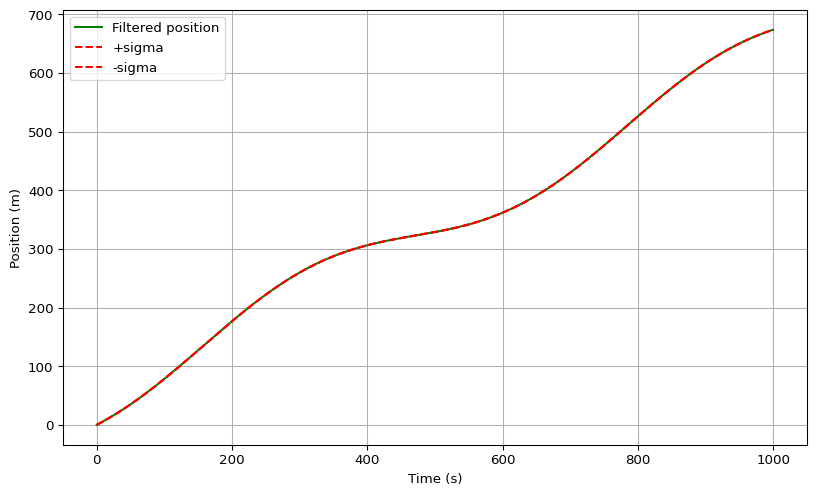

In [8]:
title = '1_kalman_filtering_no_missing_values'
key = "Position (m)"
df2 = handle_velocity_model(df, key, smoothing=False)
plot_kalman_filter(df, 'position_filtered', 'position_std', title)

# Case 2: missing values from 300 to 500

/home/acollet/anaconda3/lib/python3.8/site-packages/filterpy/kalman/kalman_filter.py:1134: UserWarning: Warning: converting a masked element to nan.
  self._mahalanobis = sqrt(float(dot(dot(self.y.T, self.SI), self.y)))


(1001, 3, 1)
(1001, 3, 3)


,Time (s),Position (m),position_filtered,velocity_filtered,acceleration_filtered,position_std,velocity_std,acceleration_std
0,0,0.000000,0.000000,0.000000,0.000000,0.199674,1.347970,0.989777
1,1,0.600000,0.594135,0.545699,0.209732,0.199020,1.135667,0.692567
2,2,1.210000,1.210435,0.728198,0.200263,0.198744,1.018700,0.491782
3,3,1.817999,1.821312,0.777596,0.155095,0.198493,0.928437,0.360972
4,4,2.431995,2.436211,0.786547,0.117577,0.198268,0.853652,0.275081
...,...,...,...,...,...,...,...,...
996,996,672.005596,672.005508,0.393441,-0.003953,0.196425,0.214382,0.006809
997,997,672.399868,672.399766,0.389615,-0.003950,0.196425,0.214382,0.006809
998,998,672.790720,672.790603,0.385809,-0.003947,0.196425,0.214382,0.006809
999,999,673.178173,673.178041,0.382026,-0.003943,0.196425,0.214382,0.006809


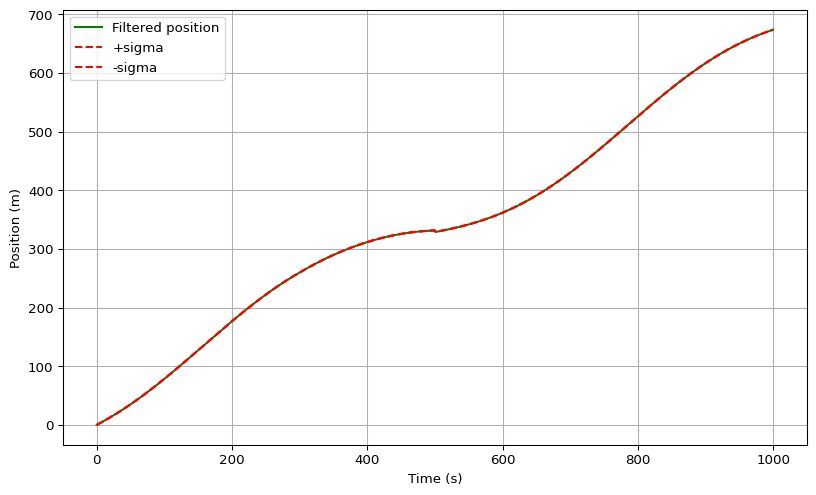

In [9]:
title = '2_kalman_filtering_normal_missing_range'
df2 = df.copy(deep=True)
df2.loc[300:500, key] = np.nan
df2 = handle_velocity_model(df2, key, smoothing=False)
plot_kalman_filter(df2, 'position_filtered', 'position_std', title)
df2

# Case 3: missing values from 300 to 800

/home/acollet/anaconda3/lib/python3.8/site-packages/filterpy/kalman/kalman_filter.py:1134: UserWarning: Warning: converting a masked element to nan.
  self._mahalanobis = sqrt(float(dot(dot(self.y.T, self.SI), self.y)))


(1001, 3, 1)
(1001, 3, 3)


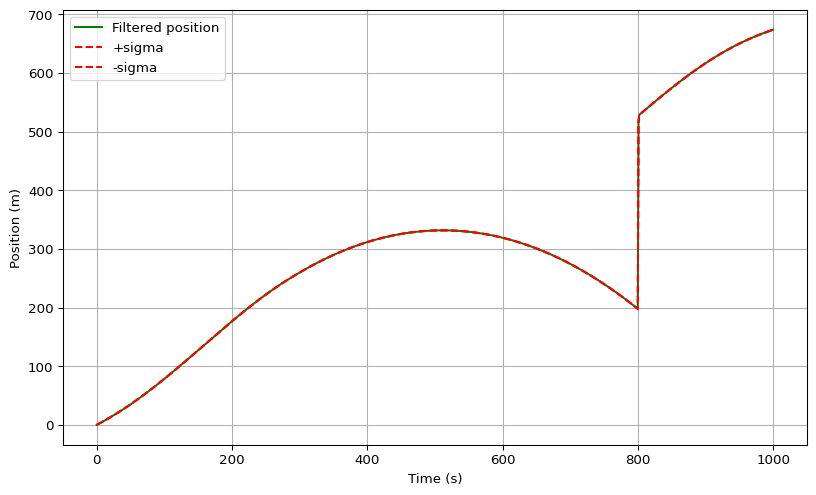

In [10]:
title = '3_kalman_filtering_big_missing_range'
df2 = df.copy(deep=True)
df2.loc[300:800, key] = np.nan
df2 = handle_velocity_model(df2, key, smoothing=False)
plot_kalman_filter(df2, 'position_filtered', 'position_std', title)

In [11]:
df2

,Time (s),Position (m),position_filtered,velocity_filtered,acceleration_filtered,position_std,velocity_std,acceleration_std
0,0,0.000000,0.000000,0.000000,0.000000,0.199674,1.347970,0.989777
1,1,0.600000,0.594135,0.545699,0.209732,0.199020,1.135667,0.692567
2,2,1.210000,1.210435,0.728198,0.200263,0.198744,1.018700,0.491782
3,3,1.817999,1.821312,0.777596,0.155095,0.198493,0.928437,0.360972
4,4,2.431995,2.436211,0.786547,0.117577,0.198268,0.853652,0.275081
...,...,...,...,...,...,...,...,...
996,996,672.005596,672.002548,0.317145,-0.002903,0.196425,0.214382,0.006809
997,997,672.399868,672.396976,0.317804,-0.002826,0.196425,0.214382,0.006809
998,998,672.790720,672.787980,0.318353,-0.002753,0.196425,0.214382,0.006809
999,999,673.178173,673.175579,0.318795,-0.002684,0.196425,0.214382,0.006809


# Case 4: missing values from 200 to 400 + 600 to 750

/home/acollet/anaconda3/lib/python3.8/site-packages/filterpy/kalman/kalman_filter.py:1134: UserWarning: Warning: converting a masked element to nan.
  self._mahalanobis = sqrt(float(dot(dot(self.y.T, self.SI), self.y)))


(1001, 3, 1)
(1001, 3, 3)


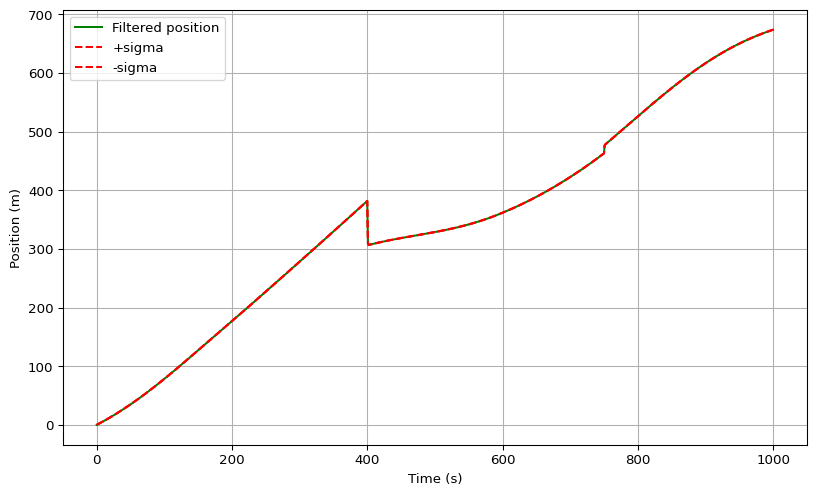

In [12]:
title = '4_kalman_filtering_two_missing_ranges'
df2 = df.copy(deep=True)
df2.loc[200:400, key] = np.nan
df2.loc[600:750, key] = np.nan
df2 = handle_velocity_model(df2, key, smoothing=False)
plot_kalman_filter(df2, 'position_filtered', 'position_std', title)

# Case 5: missing values from 200 to 400 + 600 to 750 + smoothing

(1001, 3, 1)
(1001, 3, 3)


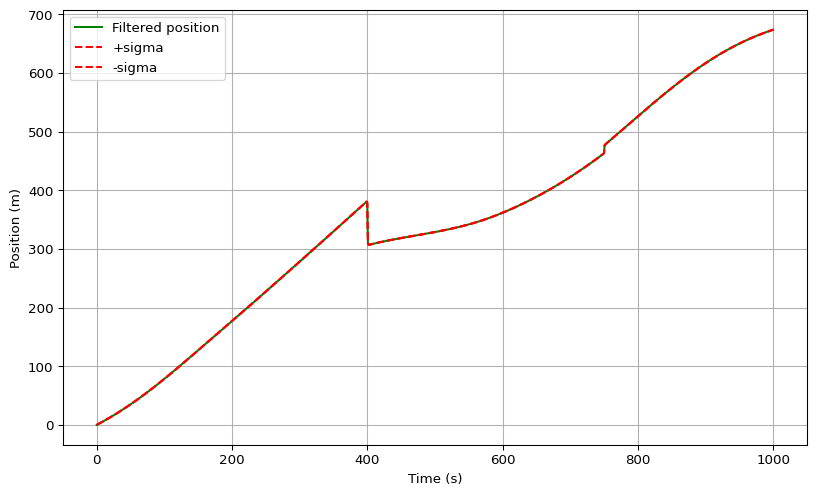

In [13]:
title = '5_kalman_smoohting_two_missing_ranges'
df2 = df.copy(deep=True)
df2.loc[200:400, key] = np.nan
df2.loc[600:750, key] = np.nan
df2 = handle_velocity_model(df2, key, smoothing=True)
plot_kalman_filter(df2, 'position_filtered', 'position_std', title)

# Case 6: missing values from 300 to 800 + smoothing

(1001, 3, 1)
(1001, 3, 3)


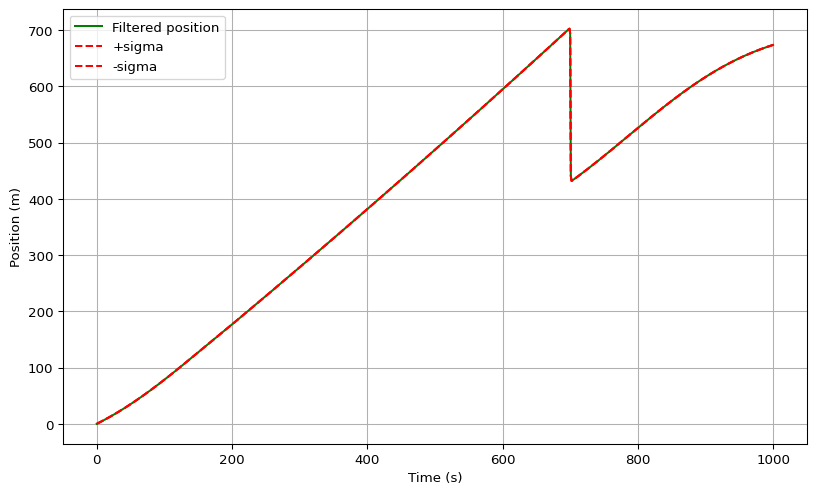

In [14]:
title = '6_kalman_smoohting_big_missing_range'
df2 = df.copy(deep=True)
df2.loc[200:700, key] = np.nan
df2 = handle_velocity_model(df2, key, smoothing=True)
plot_kalman_filter(df2, 'position_filtered', 'position_std', title)